In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from scipy.integrate import cumulative_trapezoid

In [2]:
bat_dict = pickle.load(open(r'./Data/bat_dict.pkl', 'rb'))

In [3]:
print(bat_dict.keys())
print(bat_dict["b1c0"].keys())
print(bat_dict["b1c0"]["summary"].keys())
print(bat_dict["b1c0"]["cycles"].keys())
print(bat_dict["b1c0"]["cycles"]["10"].keys())

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47'])
dict_keys(['cycle_life', 'charge_policy', 'summary', 'cycles'])
dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17'

In [4]:
b1 = []
b2 = []

for bat in bat_dict.keys():
    if bat_dict[bat]["summary"]["QD"][0] < 0.9:
        b1.append(bat)
    
    for i in range(1, len(bat_dict[bat]["summary"]["QD"])):
        if bat_dict[bat]["summary"]["QD"][i] > 1.1:
            b2.append(bat)

print(b1)
print(b2)

['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45']
['b1c0', 'b1c18', 'b2c12', 'b2c44']


In [5]:
max_cycle = -np.inf
min_cycle = np.inf

for bat in bat_dict.keys():
    if bat_dict[bat]["cycle_life"] > max_cycle:
        max_cycle = bat_dict[bat]["cycle_life"][0][0]
    
    if bat_dict[bat]["cycle_life"] < min_cycle:
        min_cycle = bat_dict[bat]["cycle_life"][0][0]

print(max_cycle, min_cycle)

2237.0 148.0


In [6]:
for bat in bat_dict.keys():
    if bat in b1:
        for key in bat_dict[bat]["summary"].keys():
            bat_dict[bat]["summary"][key] = bat_dict[bat]["summary"][key][1:]

In [7]:
q_nominal = 1.1
volt_min = 2.0
volt_max = 3.5
num_volt_points = 1000
common_volt_grid = np.linspace(volt_min, volt_max, num_volt_points)

In [8]:
def get_Q_V_curve_from_VIT(battery_id, cycle_num_str, bat_dict_local):
        cycle_data = bat_dict_local[battery_id]['cycles'][cycle_num_str]

        V_raw = np.array(cycle_data['V'])
        I_raw = np.array(cycle_data['I'])
        t_raw = np.array(cycle_data['t'])

        discharge_indices = np.where(I_raw < -0.01)[0]
        
        if len(discharge_indices) < 2:
            discharge_indices = np.where(I_raw > 0.01)[0]

        V_discharge = V_raw[discharge_indices]
        I_discharge = I_raw[discharge_indices]
        t_discharge = t_raw[discharge_indices]

            
        # Calculate dQ: current is in Amps, time in seconds. Q will be in Amp-seconds (Coulombs).
        # Convert to Amp-hours by dividing by 3600.
        # abs(I_discharge) because we want magnitude for capacity.
        # cumtrapz calculates cumulative integral of y (abs(I_discharge)) w.r.t x (t_discharge)
        Q_cumulative_Ah = cumulative_trapezoid(np.abs(I_discharge), t_discharge, initial=0) / 3600.0
        
        # Sort by V_discharge descending for interpolation
        sort_indices = np.argsort(V_discharge)[::-1]
        V_sorted_desc = V_discharge[sort_indices]
        Q_sorted_desc = Q_cumulative_Ah[sort_indices]
        
        # For np.interp, xp (V_for_interp) must be increasing.
        V_for_interp = V_sorted_desc[::-1]
        Q_for_interp = Q_sorted_desc[::-1]
        
        # Remove duplicate voltage points before interpolation if they cause issues, keeping the first occurrence
        unique_V_indices = np.unique(V_for_interp, return_index=True)[1]
        V_unique_for_interp = V_for_interp[unique_V_indices]
        Q_unique_for_interp = Q_for_interp[unique_V_indices]
            
        # Interpolate onto the common_voltage_grid
        # common_voltage_grid is MAX to MIN, so common_voltage_grid[::-1] is MIN to MAX (increasing).
        Q_interpolated_asc = np.interp(common_volt_grid[::-1], V_unique_for_interp, Q_unique_for_interp)
        
        # Return in the order of the original common_voltage_grid (VOLTAGE_MAX down to VOLTAGE_MIN)
        return Q_interpolated_asc[::-1]

In [9]:
def calculate_delta_Q_variance(battery_id, bat_dict_local, cycle_ref1_str='10', cycle_ref2_str='100'):
    Q_cycle_ref1_V = get_Q_V_curve_from_VIT(battery_id, cycle_ref1_str, bat_dict_local)
    Q_cycle_ref2_V = get_Q_V_curve_from_VIT(battery_id, cycle_ref2_str, bat_dict_local)

    if Q_cycle_ref1_V is not None and Q_cycle_ref2_V is not None:
        delta_Q_V = Q_cycle_ref2_V - Q_cycle_ref1_V
        return np.var(delta_Q_V)
    return None

In [10]:
X_data = []
y_data = []
battery_ids_for_model = []

for battery_id in bat_dict.keys():
    var_delta_Q = calculate_delta_Q_variance(battery_id, bat_dict)

    summary_cycles = bat_dict[battery_id]['summary']['cycle']
    summary_QD = bat_dict[battery_id]['summary']['QD']
    
    for i in range(len(summary_cycles)):
        current_cycle_num = summary_cycles[i]
        q_current = summary_QD[i]
        soh = (q_current / q_nominal) * 100
        X_data.append([var_delta_Q, float(current_cycle_num)])
        y_data.append(soh)
        battery_ids_for_model.append(battery_id)

In [11]:
X_data = np.array(X_data)
y_data = np.array(y_data)
battery_ids_for_model = np.array(battery_ids_for_model)
print(f"Feature matrix shape: {X_data.shape}")
print(f"Target vector shape: {y_data.shape}")

Feature matrix shape: (59220, 2)
Target vector shape: (59220,)


In [ ]:
unique_batteries = np.unique(battery_ids_for_model)

train_battery_ids, test_battery_ids = train_test_split(unique_batteries, test_size=0.25, random_state=987123)
        
train_indices = np.isin(battery_ids_for_model, train_battery_ids)
test_indices = np.isin(battery_ids_for_model, test_battery_ids)

X_train, X_test = X_data[train_indices], X_data[test_indices]
y_train, y_test = y_data[train_indices], y_data[test_indices]

In [13]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=987123, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=987123)

In [14]:
y_pred_test = rf_model.predict(X_test)
    
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)

print(f"Test Set Performance:")
print(f"  R^2 Score: {r2:.4f}")
print(f"  MAE: {mae:.4f} (SOH %)")
print(f"  RMSE: {rmse:.4f} (SOH %)")
print(f"  MSE: {mse:.4f}")

Test Set Performance:
  R^2 Score: 0.4816
  MAE: 2.2791 (SOH %)
  RMSE: 3.7644 (SOH %)
  MSE: 14.1710



Plotting SOH curve for battery: b2c4


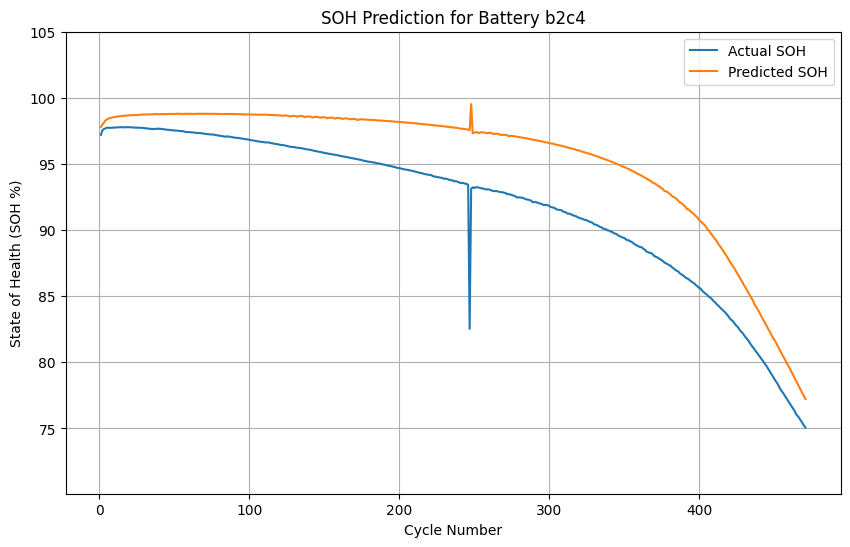

In [15]:
plot_battery_id = test_battery_ids[0]

print(f"\nPlotting SOH curve for battery: {plot_battery_id}")
        
actual_soh_cycles = []
actual_soh_values = []

battery_indices_in_original = [i for i, bid in enumerate(battery_ids_for_model) if bid == plot_battery_id]


actual_soh_cycles = X_data[battery_indices_in_original, 1]
actual_soh_values = y_data[battery_indices_in_original]

#sort by cycle number for plotting
sort_idx_plot = np.argsort(actual_soh_cycles)
actual_soh_cycles = actual_soh_cycles[sort_idx_plot]
actual_soh_values = actual_soh_values[sort_idx_plot]

var_delta_Q_plot_battery = None
first_index_for_battery = next((i for i, bid in enumerate(battery_ids_for_model) if bid == plot_battery_id), None)

if first_index_for_battery is not None:
     var_delta_Q_plot_battery = X_data[first_index_for_battery, 0]
if var_delta_Q_plot_battery is not None and len(actual_soh_cycles) > 0:
    predicted_soh_values = []
    for cycle_num in actual_soh_cycles:
        pred = rf_model.predict(np.array([[var_delta_Q_plot_battery, cycle_num]]))
        predicted_soh_values.append(pred[0])
    plt.figure(figsize=(10, 6))
    plt.plot(actual_soh_cycles, actual_soh_values,  label='Actual SOH', markersize=4)
    plt.plot(actual_soh_cycles, predicted_soh_values, label='Predicted SOH')
    plt.xlabel('Cycle Number')
    plt.ylabel('State of Health (SOH %)')
    plt.title(f'SOH Prediction for Battery {plot_battery_id}')
    plt.legend()
    plt.grid(True)
    plt.ylim(min(min(actual_soh_values)-5, min(predicted_soh_values)-5), 105)
    plt.show()

In [16]:
def extract_early_life_features(battery_id, bat_dict_local, n_early_cycles=100):
    features = {}

    Q10 = get_Q_V_curve_from_VIT(battery_id, '10', bat_dict_local)
    Q100 = get_Q_V_curve_from_VIT(battery_id, '100', bat_dict_local)
    features['var_delta_Q_100_10'] = np.var(Q100 - Q10)

    summary = bat_dict_local[battery_id].get('summary', {})

    summary_cycles = np.array(summary['cycle'])
    
    early_indices = np.where(summary_cycles <= n_early_cycles)[0]

    def get_early_summary_metric(key_name):
        if key_name in summary:
            data_array = np.array(summary[key_name])[early_indices]
            if len(data_array) > 0:
                return data_array
        return np.array([])

    ir_early = get_early_summary_metric('IR')
    features['IR_mean_early'] = np.mean(ir_early) if len(ir_early) > 0 else np.nan

    chargetime_early = get_early_summary_metric('chargetime')
    features['chargetime_mean_early'] = np.mean(chargetime_early) if len(chargetime_early) > 0 else np.nan
    
    tavg_early = get_early_summary_metric('Tavg')
    features['Tavg_mean_early'] = np.mean(tavg_early) if len(tavg_early) > 0 else np.nan

    return features

In [17]:
X_data_list = []
y_data_list = []
battery_ids_for_model = [] 

In [18]:
feature_names = ['var_delta_Q_100_10', 'IR_mean_early', 'chargetime_mean_early', 'Tavg_mean_early', 'cycle_number']

for battery_id in list(bat_dict.keys()):
        early_features_dict = extract_early_life_features(battery_id, bat_dict, n_early_cycles=100)
        summary = bat_dict[battery_id].get('summary', {})

        summary_cycles = np.array(summary['cycle'])
        summary_QD = np.array(summary['QD'])

        for i in range(len(summary_cycles)):
            current_cycle_num = summary_cycles[i]
            Q_current = summary_QD[i]
            soh = (Q_current /q_nominal) * 100
            
            current_features = [
                early_features_dict['var_delta_Q_100_10'],
                early_features_dict['IR_mean_early'],
                early_features_dict['chargetime_mean_early'],
                early_features_dict['Tavg_mean_early'],
                float(current_cycle_num)
            ]
            X_data_list.append(current_features)
            y_data_list.append(soh)
            battery_ids_for_model.append(battery_id)


In [19]:
X_data = np.array(X_data_list)
y_data = np.array(y_data_list)
battery_ids_for_model = np.array(battery_ids_for_model)

print(f"\nTotal data points: {X_data.shape[0]}")
print(f"Number of features: {X_data.shape[1] -1 } (excluding cycle_number)")
print(f"Feature names (in order for the model): {feature_names}")


Total data points: 59220
Number of features: 4 (excluding cycle_number)
Feature names (in order for the model): ['var_delta_Q_100_10', 'IR_mean_early', 'chargetime_mean_early', 'Tavg_mean_early', 'cycle_number']


In [ ]:
X_train, X_test, y_train, y_test = None, np.array([]), None, np.array([])
train_battery_ids, test_battery_ids = np.array([]), np.array([])

unique_batteries_in_model = np.unique(battery_ids_for_model)

train_battery_ids, test_battery_ids = train_test_split(unique_batteries_in_model, test_size=0.25, random_state=987123)
        
train_indices = np.isin(battery_ids_for_model, train_battery_ids)
test_indices = np.isin(battery_ids_for_model, test_battery_ids)

X_train, X_test = X_data[train_indices], X_data[test_indices]
y_train, y_test = y_data[train_indices], y_data[test_indices]

In [21]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=987123, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=987123)

In [22]:
y_pred_test = rf_model.predict(X_test)
        
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
        
print(f"Test Set Performance:")
print(f"  R^2 Score: {r2:.4f}")
print(f"  MAE: {mae:.4f} (SOH %)")
print(f"  MSE: {mse:.4f}")
print(f"  RMSE: {rmse:.4f} (SOH %)")

Test Set Performance:
  R^2 Score: 0.4834
  MAE: 2.3686 (SOH %)
  MSE: 14.1238
  RMSE: 3.7582 (SOH %)


In [23]:
print("\nFeature Importances:")

importances = rf_model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
for i in sorted_indices:
    print(f"  {feature_names[i]}: {importances[i]:.4f}")


Feature Importances:
  cycle_number: 0.5908
  var_delta_Q_100_10: 0.1941
  IR_mean_early: 0.1487
  chargetime_mean_early: 0.0444
  Tavg_mean_early: 0.0221


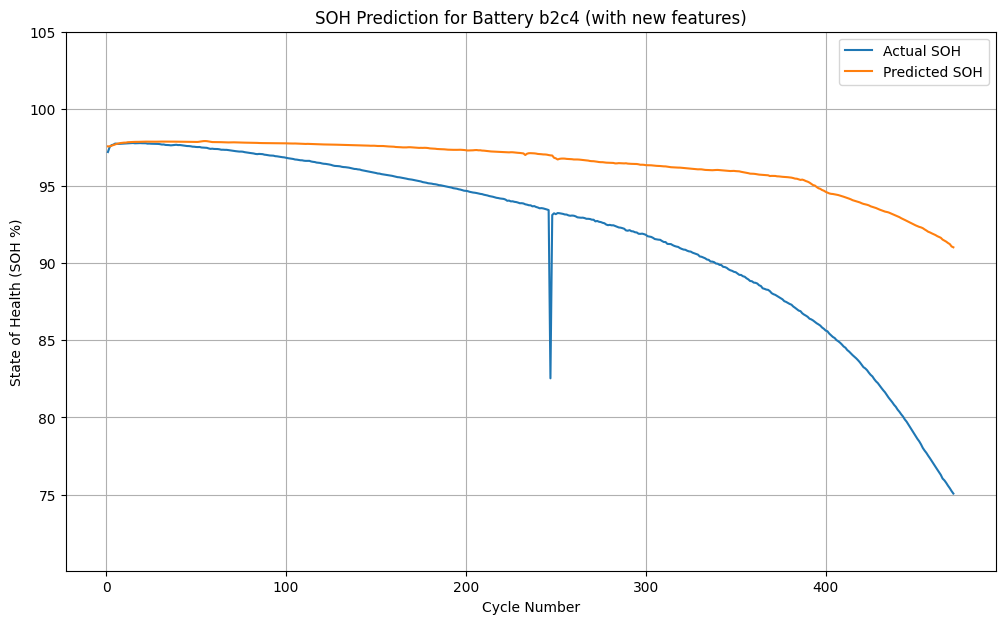

In [ ]:
available_test_ids = [bid for bid in test_battery_ids if bid in battery_ids_for_model]
plot_battery_id = available_test_ids[0]

battery_original_indices = np.where(battery_ids_for_model == plot_battery_id)[0]
    
X_battery_plot = X_data[battery_original_indices]
y_actual_battery_plot = y_data[battery_original_indices]
actual_soh_cycles_plot = X_battery_plot[:, feature_names.index('cycle_number')]


sort_idx_plot = np.argsort(actual_soh_cycles_plot)
actual_soh_cycles_plot = actual_soh_cycles_plot[sort_idx_plot]
y_actual_battery_plot_sorted = y_actual_battery_plot[sort_idx_plot]
X_battery_plot_sorted = X_battery_plot[sort_idx_plot]

predicted_soh_values_plot = rf_model.predict(X_battery_plot_sorted)
plt.figure(figsize=(12, 7))
plt.plot(actual_soh_cycles_plot, y_actual_battery_plot_sorted, label='Actual SOH', markersize=3)
plt.plot(actual_soh_cycles_plot, predicted_soh_values_plot, label='Predicted SOH')
plt.xlabel('Cycle Number')
plt.ylabel('State of Health (SOH %)')
plt.title(f'SOH Prediction for Battery {plot_battery_id} (with new features)')
plt.legend()
plt.grid(True)
min_val_plot = 50 # Default min y
if len(y_actual_battery_plot_sorted) > 0 :
    min_val_plot = min(np.min(y_actual_battery_plot_sorted)-5, np.min(predicted_soh_values_plot)-5)
plt.ylim(max(0, min_val_plot), 105) 
plt.show()